In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, count


In [2]:
spark = SparkSession.builder.master('local[*]').appName('used-car-price').config('spark.executor.memory', '6g').getOrCreate()

24/09/10 19:57:33 WARN Utils: Your hostname, langchain resolves to a loopback address: 127.0.1.1; using 192.168.0.103 instead (on interface wlp3s0)
24/09/10 19:57:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/10 19:57:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/10 19:57:34 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
spark = SparkSession.builder.master('local[*]').appName('used-car-price')\
.config("spark.executor.instances", "1")\
.config("spark.executor.memory", "6g")\
.config("spark.driver.memory", "6g")\
.config("spark.executor.memoryOverhead", "8g")\
.getOrCreate()

24/09/10 19:57:35 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [4]:
csv_file_path = '../data/train.csv'
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

In [5]:
df.show()

+---+-------------+--------------------+----------+------+-------------+--------------------+--------------------+--------------------+-------+--------------------+-----------+-----+
| id|        brand|               model|model_year|milage|    fuel_type|              engine|        transmission|             ext_col|int_col|            accident|clean_title|price|
+---+-------------+--------------------+----------+------+-------------+--------------------+--------------------+--------------------+-------+--------------------+-----------+-----+
|  0|         MINI|       Cooper S Base|      2007|213000|     Gasoline|172.0HP 1.6L 4 Cy...|                 A/T|              Yellow|   Gray|       None reported|        Yes| 4200|
|  1|      Lincoln|               LS V8|      2002|143250|     Gasoline|252.0HP 3.9L 8 Cy...|                 A/T|              Silver|  Beige|At least 1 accide...|        Yes| 4999|
|  2|    Chevrolet|   Silverado 2500 LT|      2002|136731|E85 Flex Fuel|320.0HP 5.3L 

In [6]:
# engine_counts = df.groupBy('engine').agg(count('model').alias('count'))
# df = df.join(engine_counts, on='engine', how='left')
# df = df.withColumn('engine', when(col('count') == 1, 'Rare_engine').otherwise(col('engine')))
# df = df.drop('count')

In [7]:
# engine_counts = df.groupBy('engine').agg(count('engine').alias('count')).orderBy('count')
# engine_counts.filter(col('count') > 7).show(n=52)

In [8]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import re
from pyspark.sql import functions as F

def clean_engine(engine):
    engine = re.sub(r"[^a-zA-Z0-9\s]", "", engine)
    return engine

clean_engine_udf = udf(clean_engine, StringType())
df = df.withColumn("engine", clean_engine_udf(F.col("engine")))


In [9]:
df.columns

['id',
 'brand',
 'model',
 'model_year',
 'milage',
 'fuel_type',
 'engine',
 'transmission',
 'ext_col',
 'int_col',
 'accident',
 'clean_title',
 'price']

In [10]:
# model_counts = df.groupBy('model').agg(count('model').alias('count'))
# df = df.join(model_counts, on='model', how='left')
# df = df.withColumn('model', when(col('count') == 1, 'Rare_model').otherwise(col('model')))
# df = df.drop('count')

In [11]:
# model_counts = df.groupBy('model').agg(count('model').alias('count')).orderBy('count')
# model_counts.filter(col('count') > 3).show(n=52)

In [12]:
from pyspark.sql.functions import col, when,regexp_replace,lower
df = df.withColumn(
    "transmission",
    when(col("transmission").contains("At/Mt") | col("transmission").contains("AT/MT"), 
          regexp_replace(col("transmission"), "AT/MT|At/Mt", "automatic/manual"))
    .when(col("transmission").contains("A/T") | col("transmission").contains("AT"), 
         regexp_replace(col("transmission"), "A/T|AT", "automatic"))
    .when(col("transmission").contains("Mt") | col("transmission").contains("M/T"), 
          regexp_replace(col("transmission"), "Mt|M/T", "manual"))
    
    .when(col("transmission").contains("F"), "single-speed fixed gear")
    .when(col("transmission").contains("DCT"), "dual clutch automatic")
    .when(col("transmission").contains("CVT"), "continuously variable transmission")
    .when(col("transmission").contains("5-Speed M/T"), "5-Speed manual")
    .otherwise(col("transmission"))
)

In [13]:
df = df.withColumn("transmission", lower(col("transmission")))

In [14]:
df.groupBy("transmission").agg(F.count("*").alias("count")).orderBy("count").show(truncate=False)

+--------------------------------------------------+-----+
|transmission                                      |count|
+--------------------------------------------------+-----+
|dual clutch automatic                             |18   |
|6 speed automatic/manual                          |20   |
|6-speed                                           |27   |
|8-speed manual                                    |28   |
|7-speed                                           |29   |
|6-speed electronically controlled automatic with o|31   |
|9-speed automatic with auto-shift                 |33   |
|6 speed manual                                    |37   |
|10-speed automatic with overdrive                 |40   |
|variable                                          |66   |
|–                                                 |87   |
|2                                                 |91   |
|2-speed automatic                                 |93   |
|single-speed fixed gear                           |102 

In [15]:
df.groupBy("transmission").agg(F.count("*").alias("count")).orderBy("count", ascending=False).show(truncate=False)

+----------------------------------+-----+
|transmission                      |count|
+----------------------------------+-----+
|automatic                         |60595|
|8-speed automatic                 |29096|
|6-speed automatic                 |20843|
|transmission w/dual shift mode    |19255|
|6-speed manual                    |12209|
|7-speed automatic                 |11302|
|10-speed automatic                |11208|
|9-speed automatic                 |6191 |
|5-speed automatic                 |3376 |
|continuously variable transmission|2819 |
|4-speed automatic                 |2594 |
|5-speed manual                    |2409 |
|1-speed automatic                 |2234 |
|manual                            |1206 |
|7-speed automatic with auto-shift |1172 |
|8-speed automatic with auto-shift |549  |
|7-speed manual                    |506  |
|transmission overdrive switch     |156  |
|6-speed automatic with auto-shift |111  |
|single-speed fixed gear           |102  |
+----------

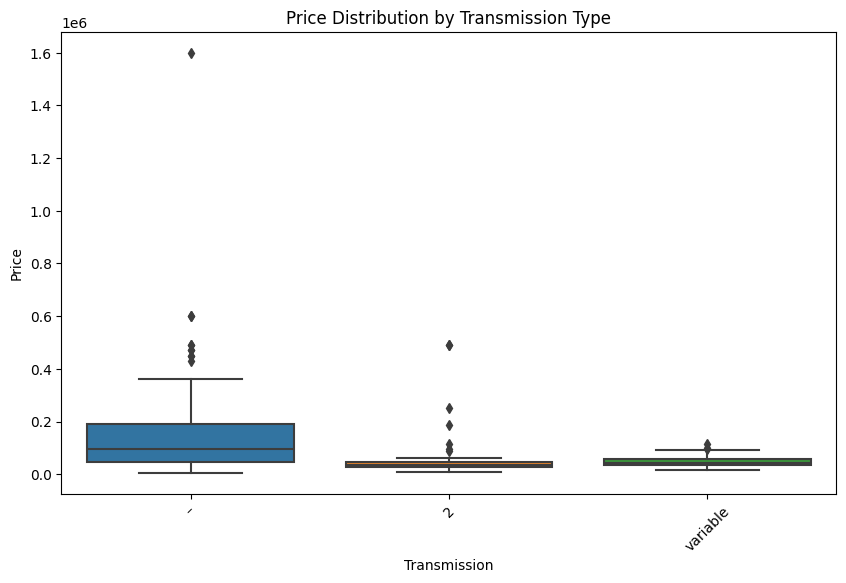

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

filtered_df = df.filter(col("transmission").isin("–", "2", "variable"))
pandas_df = filtered_df.select("transmission", "price").toPandas()

plt.figure(figsize=(10, 6))
sns.boxplot(x='transmission', y='price', data=pandas_df)
plt.title('Price Distribution by Transmission Type')
plt.xlabel('Transmission')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()


In [17]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
filtered_df = df.filter(col("transmission").isin("–", "2", "variable"))
pandas_filtered_df = filtered_df.select("transmission", "price").toPandas()

model = ols('price ~ transmission', data=pandas_filtered_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)


                    sum_sq     df          F        PR(>F)
transmission  6.695251e+11    2.0  18.739447  2.726361e-08
Residual      4.305238e+12  241.0        NaN           NaN


It could be better to treat these features separately rather than grouping them into an unknown category.

The ANOVA test shows that the transmission feature has a statistically significant impact on price since the p-value is 
well below the standard threshold of 0.05. This means that "–", "2", and "variable" do contribute to differences in the 
price, and grouping them as "unknown" could result in information loss.

In [18]:
df = df.withColumn(
    "transmission",
    when(col("transmission") == "–", "unknown-transmission")
    .otherwise(col("transmission"))
)

df.select('transmission').distinct().show()

+--------------------+
|        transmission|
+--------------------+
|6-speed electroni...|
|6 speed automatic...|
|   5-speed automatic|
|7-speed automatic...|
|            variable|
|  10-speed automatic|
|   2-speed automatic|
|           automatic|
|             7-speed|
|10-speed automati...|
|      7-speed manual|
|single-speed fixe...|
|   6-speed automatic|
|transmission over...|
|9-speed automatic...|
|   8-speed automatic|
|              manual|
|      5-speed manual|
|      6 speed manual|
|      8-speed manual|
+--------------------+
only showing top 20 rows



In [19]:
# df = df.withColumn(
#     "transmission",
#     when(col("transmission").isin("unknown-transmission", "2","variable"), "unknown")  
#     .otherwise(col("transmission"))
# )


In [20]:

df.select('transmission').distinct().show()

+--------------------+
|        transmission|
+--------------------+
|6-speed electroni...|
|6 speed automatic...|
|   5-speed automatic|
|7-speed automatic...|
|            variable|
|  10-speed automatic|
|   2-speed automatic|
|           automatic|
|             7-speed|
|10-speed automati...|
|      7-speed manual|
|single-speed fixe...|
|   6-speed automatic|
|transmission over...|
|9-speed automatic...|
|   8-speed automatic|
|              manual|
|      5-speed manual|
|      6 speed manual|
|      8-speed manual|
+--------------------+
only showing top 20 rows



In [21]:
df.show()

+---+-------------+--------------------+----------+------+-------------+--------------------+--------------------+--------------------+-------+--------------------+-----------+-----+
| id|        brand|               model|model_year|milage|    fuel_type|              engine|        transmission|             ext_col|int_col|            accident|clean_title|price|
+---+-------------+--------------------+----------+------+-------------+--------------------+--------------------+--------------------+-------+--------------------+-----------+-----+
|  0|         MINI|       Cooper S Base|      2007|213000|     Gasoline|1720HP 16L 4 Cyli...|           automatic|              Yellow|   Gray|       None reported|        Yes| 4200|
|  1|      Lincoln|               LS V8|      2002|143250|     Gasoline|2520HP 39L 8 Cyli...|           automatic|              Silver|  Beige|At least 1 accide...|        Yes| 4999|
|  2|    Chevrolet|   Silverado 2500 LT|      2002|136731|E85 Flex Fuel|3200HP 53L 8 

In [22]:
df.groupBy("transmission").agg(F.count("*").alias("count")).orderBy("count", ascending=False).show(truncate=False)

+----------------------------------+-----+
|transmission                      |count|
+----------------------------------+-----+
|automatic                         |60595|
|8-speed automatic                 |29096|
|6-speed automatic                 |20843|
|transmission w/dual shift mode    |19255|
|6-speed manual                    |12209|
|7-speed automatic                 |11302|
|10-speed automatic                |11208|
|9-speed automatic                 |6191 |
|5-speed automatic                 |3376 |
|continuously variable transmission|2819 |
|4-speed automatic                 |2594 |
|5-speed manual                    |2409 |
|1-speed automatic                 |2234 |
|manual                            |1206 |
|7-speed automatic with auto-shift |1172 |
|8-speed automatic with auto-shift |549  |
|7-speed manual                    |506  |
|transmission overdrive switch     |156  |
|6-speed automatic with auto-shift |111  |
|single-speed fixed gear           |102  |
+----------

In [23]:
df.groupBy('transmission').agg(count('transmission').alias('count')).orderBy('count').show()

+--------------------+-----+
|        transmission|count|
+--------------------+-----+
|dual clutch autom...|   18|
|6 speed automatic...|   20|
|             6-speed|   27|
|      8-speed manual|   28|
|             7-speed|   29|
|6-speed electroni...|   31|
|9-speed automatic...|   33|
|      6 speed manual|   37|
|10-speed automati...|   40|
|            variable|   66|
|unknown-transmission|   87|
|                   2|   91|
|   2-speed automatic|   93|
|single-speed fixe...|  102|
|6-speed automatic...|  111|
|transmission over...|  156|
|      7-speed manual|  506|
|8-speed automatic...|  549|
|7-speed automatic...| 1172|
|              manual| 1206|
+--------------------+-----+
only showing top 20 rows



In [24]:
df.select('accident').distinct().show()

+--------------------+
|            accident|
+--------------------+
|At least 1 accide...|
|       None reported|
|                NULL|
+--------------------+



In [25]:
null_count = df.filter(col("accident").isNull()).count()
print(f"Number of null rows in 'accident' column: {null_count}")

Number of null rows in 'accident' column: 2452


In [26]:
# df = df.fillna({"accident": "unknown_accident"})
# null_count = df.filter(col("accident").isNull()).count()
# print(f"Number of null rows in 'accident' column: {null_count}")


In [27]:

df = df.withColumn(
    "accident",
    when(col("accident") == "At least 1 accident or damage reported", "damage reported")
    .otherwise(col("accident"))
)
df.select('accident').distinct().show()

+---------------+
|       accident|
+---------------+
|  None reported|
|damage reported|
|           NULL|
+---------------+



In [28]:
null_count = df.filter(col("fuel_type").isNull()).count()
print(f"Number of null rows in 'fuel_type' column: {null_count}")

Number of null rows in 'fuel_type' column: 5083


In [29]:
# df = df.fillna({"fuel_type": "unknown_fuel"})
# null_count = df.filter(col("fuel_type").isNull()).count()
# print(f"Number of null rows in 'fuel_type' column: {null_count}")


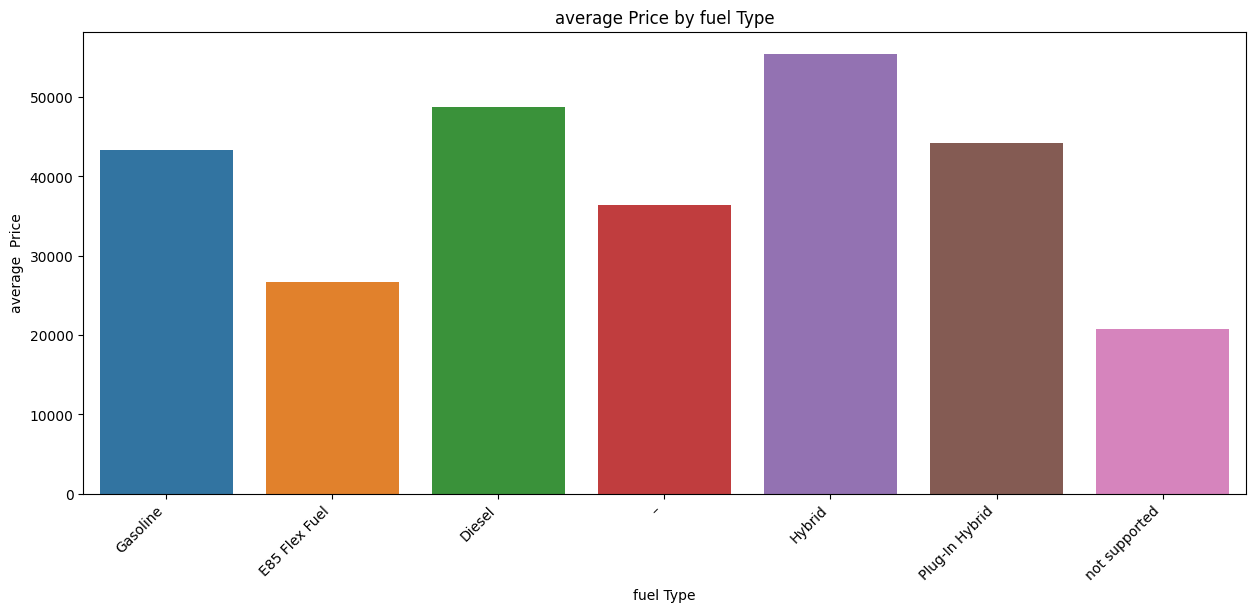

In [30]:
avg_price_df = df.groupBy('fuel_type').agg(F.mean('price').alias('avg_price'))
avg_price_pdf = avg_price_df.toPandas()

plt.figure(figsize=(15, 6)) 
sns.barplot(x='fuel_type', y='avg_price', data=avg_price_pdf)

plt.xlabel('fuel Type')
plt.ylabel('average  Price')
plt.title('average Price by fuel Type')
plt.xticks(rotation=45, ha='right')  

plt.show()

In [31]:
df.select('fuel_type').distinct().show()

+--------------+
|     fuel_type|
+--------------+
|      Gasoline|
| E85 Flex Fuel|
|        Diesel|
|             –|
|        Hybrid|
|Plug-In Hybrid|
| not supported|
|          NULL|
+--------------+



In [32]:
df = df.withColumn(
    "fuel_type",
    when(col("fuel_type") == "–", "unknown-name-fuel")
    .otherwise(col("fuel_type"))
)

df.select('fuel_type').distinct().show()

+-----------------+
|        fuel_type|
+-----------------+
|         Gasoline|
|    E85 Flex Fuel|
|           Diesel|
|           Hybrid|
|   Plug-In Hybrid|
|unknown-name-fuel|
|    not supported|
|             NULL|
+-----------------+



In [33]:
df.select('clean_title').distinct().show()

+-----------+
|clean_title|
+-----------+
|        Yes|
|       NULL|
+-----------+



In [34]:
df.filter(col('clean_title').isNull()).count()

21419

In [35]:
# df = df.fillna({"clean_title": "unknown_title"})
# null_count = df.filter(col("clean_title").isNull()).count()
# print(f"Number of null rows in 'clean_title' column: {null_count}")

In [36]:
def remove_outliers_iqr(df, column):

    Q1 = df.approxQuantile(column, [0.25], 0.01)[0]
    Q3 = df.approxQuantile(column, [0.75], 0.01)[0]
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR


    df_out = df.filter((F.col(column) >= lower_bound) & (F.col(column) <= upper_bound))
    return df_out

df_train_no_outliers = remove_outliers_iqr(df, 'milage')
df_train_no_outliers = remove_outliers_iqr(df_train_no_outliers, 'price')

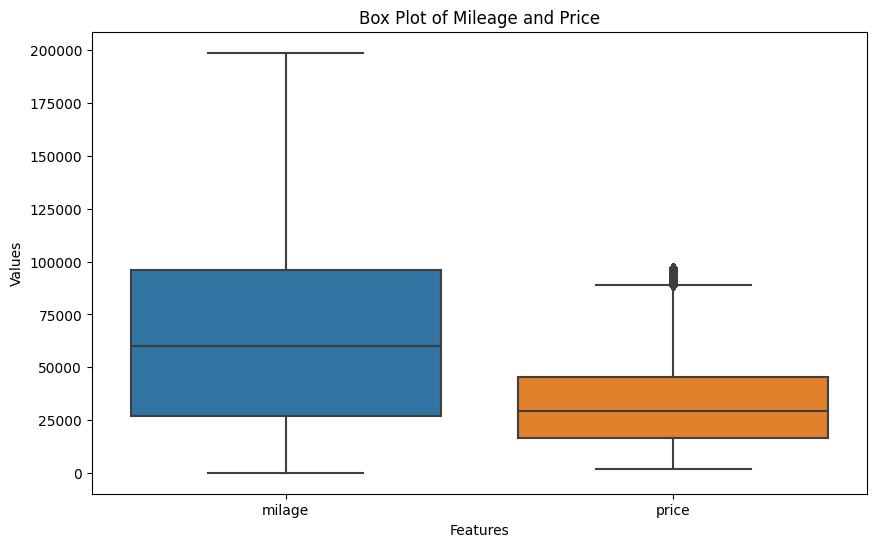

In [37]:
pandas_df = df_train_no_outliers.toPandas()

plt.figure(figsize=(10, 6))
sns.boxplot(data=pandas_df[['milage', 'price']])
plt.title('Box Plot of Mileage and Price')
plt.xlabel('Features')
plt.ylabel('Values')

plt.show()

In [38]:
df_train_no_outliers.show()

+---+-------------+--------------------+----------+------+-------------+--------------------+--------------------+--------------------+-------+---------------+-----------+-----+
| id|        brand|               model|model_year|milage|    fuel_type|              engine|        transmission|             ext_col|int_col|       accident|clean_title|price|
+---+-------------+--------------------+----------+------+-------------+--------------------+--------------------+--------------------+-------+---------------+-----------+-----+
|  1|      Lincoln|               LS V8|      2002|143250|     Gasoline|2520HP 39L 8 Cyli...|           automatic|              Silver|  Beige|damage reported|        Yes| 4999|
|  2|    Chevrolet|   Silverado 2500 LT|      2002|136731|E85 Flex Fuel|3200HP 53L 8 Cyli...|           automatic|                Blue|   Gray|  None reported|        Yes|13900|
|  3|      Genesis|    G90 5.0 Ultimate|      2017| 19500|     Gasoline|4200HP 50L 8 Cyli...|transmission w/du

In [39]:
output_path = "../data/cleaned_train.csv"
df_train_no_outliers.write.csv(output_path, header=True, mode='overwrite')
